# Flow over a cylinder with source panels

In [40]:
%run resources.ipynb

## Geometry

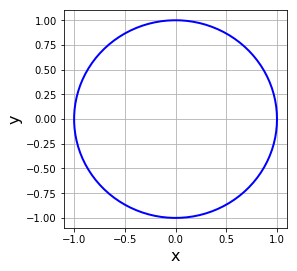

In [41]:
# free stream instance with speed 1.0, angle 0.0
u_inf = 1.0

# define the cylinder
R =1.0
theta = np.linspace(0, 2*np.pi, 100)
x_cyl, y_cyl = R*np.cos(theta), R*np.sin(theta)

# plot cylinder
size=4
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cyl, y_cyl, color='b', linestyle='-', linewidth=2)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

## Discretization into panels

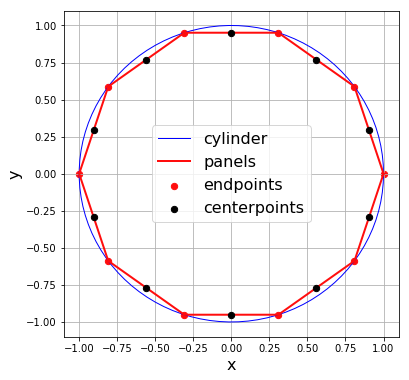

In [42]:
N_panels = 10

# endpoints of panels
x_ends = R*np.cos(np.linspace(0, 2*np.pi, N_panels+1))
y_ends = R*np.sin(np.linspace(0, 2*np.pi, N_panels+1))

# panel definitions
panels = np.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plot the panels
size=6
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cyl, y_cyl, label='cylinder', color='b', linestyle='-', linewidth=1)
plt.plot(x_ends, y_ends, label='panels', color='#FF0D0D', linestyle='-', linewidth=2)
plt.scatter([p.xa for p in panels], [p.ya for p in panels], label='endpoints', color='#FF0D0D', s=40)
plt.scatter([p.xc for p in panels], [p.yc for p in panels], label='centerpoints', color='k', s=40, zorder=3)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

## Flow-tangency boundary condition

$$u_r = \frac{\sigma}{2\pi r}$$

$$\phi = \frac{\sigma}{2\pi}\ln{r}$$

$$u_n\left(x,y\right) = \frac{\partial\phi}{\partial n}\left(x,y\right)$$

Velocity potential in Cartesian coordinates of a source sheet on a panel:

$$\phi\left(x,y\right) = \frac{\sigma}{2\pi}\int_\text{panel}\ln\sqrt{\left(x-x\left(s\right)\right)^2 + \left(y-y\left(s\right)\right)^2}ds$$

total velocity potential at a given point:

$$\phi\left(x,y\right) = \sum_{j=1}^{N_p}\frac{\sigma_j}{4\pi}\int\ln\left(\left(x-x_j\left(s_j\right)\right)^2 + \left(y-y_j\left(s_j\right)\right)^2\right)ds_j$$

superimpose freestream:

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p}\frac{\sigma_j}{4\pi}\int\ln\left(\left(x-x_j\left(s_j\right)\right)^2 + \left(y-y_j\left(s_j\right)\right)^2\right)ds_j$$

this leads to:

$$0 = U_\infty \cos{\beta_i} + \sum_{j=1}^{N_p}\frac{\sigma_j}{2\pi}\int\frac{\left(x_{c_i}-x_j\left(s_j\right)\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\left(s_j\right)\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\left(s_j\right)\right)^2 + \left(y_{c_i}-y_j\left(s_j\right)\right)^2} ds_j$$

where

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos{\beta_i} \quad \text{and} \quad \frac{\partial y_{c_i}}{\partial n_i} = \sin{\beta_i}$$

and

$$x_j\left(s_j\right) = x_{a_j} - \sin\left(\beta_j\right)s_j$$

$$y_j\left(s_j\right) = y_{a_j} + \cos\left(\beta_j\right)s_j$$

finally:

$$0 = U_\infty \cos{\beta_i} + \frac{\sigma_i}{2} + \sum_{j=1, j\neq i}^{N_p}\frac{\sigma_j}{2\pi}\int\frac{\left(x_{c_i}-x_j\left(s_j\right)\right)\cos\beta_i + \left(y_{c_i}-y_j\left(s_j\right)\right)\sin\beta_i}{\left(x_{c_i}-x_j\left(s_j\right)\right)^2 + \left(y_{c_i}-y_j\left(s_j\right)\right)^2} ds_j$$

In [43]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))*np.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))*np.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

## Solving the linear system

We just developed an equation to enforce a flow-tangency condition on the $i$-th panel. There are `N_panels` panels $i$ and `N_panels` unknown strengths $\sigma_i$. Therefore, the problem represents solving a linear system of equations of the form

$$[A][\sigma] = [b]$$

where

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, if } i=j \cr
\frac{1}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & \mbox{, if } i\neq j
\end{matrix}
\end{cases}$$

and

$$b_i = - U_\infty \cos\beta_i$$

for $1\leq i,j \leq N_p$. Let's fill a matrix $A$ and a right-hand side vector $b$ with the necessary values:

In [44]:
# compute source influence matrix
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 1.0/(2.0*np.pi)*integral_normal(p_i, p_j)
            
# compute RHS
b = -u_inf*np.cos([p.beta for p in panels])

# solve the linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

## Pressure coefficient on surface

$$C_{p_i} = 1 - \left(\frac{u_{t_i}}{U_\infty}\right)^2$$

$$u_{t_i} = \frac{\partial}{\partial t_i}\left\lbrace\phi\left(x_{c_i},y_{c_i}\right)\right\rbrace$$

$$u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

with

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i$$

In [45]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))*np.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))*np.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))**2
                 +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [46]:
# compute matrix
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 1.0/(2.0*np.pi)*integral_tangential(p_i, p_j)
            
# compute RHS
b = -u_inf*np.sin([panel.beta for panel in panels])

# compute tangential velocities
vt = np.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [47]:
# calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

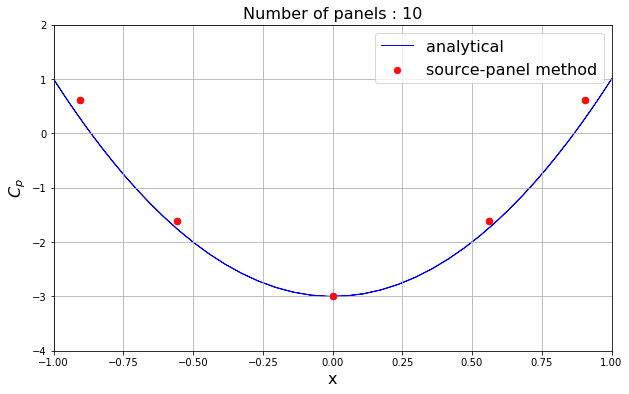

In [48]:
#plots
cp_analytical = 1.0 - 4*(y_cyl/R)**2

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(x_cyl, cp_analytical, label='analytical', color='b', linestyle='-', linewidth=1, zorder=1)
plt.scatter([p.xc for p in panels], [p.cp for p in panels], label='source-panel method',
            color='#FF0D0D', s=40, zorder=2)
plt.title('Number of panels : %d' % N_panels, fontsize=16)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-1.0, 1.0)
plt.ylim(-4.0, 2.0);

## *Challenge Task*

Cartesian velocity components:

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

$$u\left(x,y\right) = U_\infty + \sum_{j=1}^{N_p}\frac{\sigma_j}{2\pi}\int\frac{x-x_j\left(s_j\right)}{\left(x-x_j\left(s_j\right)\right)^2 + \left(y-y_j\left(s_j\right)\right)^2}ds_j$$

$$v\left(x,y\right) = \sum_{j=1}^{N_p}\frac{\sigma_j}{2\pi}\int\frac{y-y_j\left(s_j\right)}{\left(x-x_j\left(s_j\right)\right)^2 + \left(y-y_j\left(s_j\right)\right)^2}ds_j$$

In [53]:
# create mesh grid
N = 50
x_start, x_end = -5.0, 5.0
y_start, y_end = -5.0, 5.0
x, y = np.linspace(x_start, x_end, N), np.linspace(y_start, y_end, N)
X, Y = np.meshgrid(x, y)

# evaluate u integral
def u_integral(X, Y, p):
    """
    evaluates integral in u equation
    
    Parameters
    ----------
    X: float
        2D numpy array as generated by numpy.meshgrid
    Y: float
        2D numpy array as generated by numpy.meshgrid
    p: Panel object
    """
    
    def integrand(s):
        return (X - (p.xa-np.sin(p.beta)*s))/((X-(p.xa-np.sin(p.beta)*s))**2 + (Y-(p.ya+np.cos(p.beta)*s))**2)
    return integrate.quad(integrand, 0.0, p.length)[0]

# evaluate v integral
def v_integral(X, Y, p):
    """
    evaluates integral in v equation
    
    Parameters
    ----------
    X: float
        2D numpy array as generated by numpy.meshgrid
    Y: float
        2D numpy array as generated by numpy.meshgrid
    p: Panel object
    """
    
    def integrand(s):
        return (Y - (p.ya-np.sin(p.beta)*s))/((X-(p.xa-np.sin(p.beta)*s))**2 + (Y-(p.ya+np.cos(p.beta)*s))**2)
    return integrate.quad(integrand, 0.0, p.length)[0]



u = u_inf*np.ones(X.shape)
v = np.zeros(X.shape)

for panel in panels:
    u += panel.sigma/(2.0*np.pi)*u_integral(X, Y, panel)
    v += panel.sigma/(2.0*np.pi)*v_integral(X, Y, panel)
    
#plots
plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cyl, y_cyl, label='cylinder', color='b', linestyle='-', linewidth=1)
plt.plot(x_ends, y_ends, label='panels', color='#FF0D0D', linestyle='-', linewidth=2)
plt.scatter([p.xa for p in panels], [p.ya for p in panels], label='endpoints', color='#FF0D0D', s=40)
plt.scatter([p.xc for p in panels], [p.yc for p in panels], label='centerpoints', color='k', s=40, zorder=3)
plt.legend(loc='best', prop={'size':16})
plt.streamplot(X, Y, u, v, density=2, arrowsize=1, arrowstyle='->')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end);

error: Supplied function does not return a valid float.